In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import os
from pathlib import Path
import re
import seaborn as sns
from scipy import stats
import scipy

In [208]:
def plot_cdf(data, bins_count):
    count, bins_count = np.histogram(data, bins=bins_count)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.plot(bins_count[1:], cdf, label="CDF")
    plt.legend()
def plot_hist_ecdf(data, bins_count, compiler, ratio):
    fig = plt.figure(figsize=(8,6))
    ax = sns.histplot(data, kde=False, stat='probability', bins=20).set(title=f'{compiler}_{ratio}')
    ax = sns.ecdfplot(data, label = 'ecdf')
    ax.set(xlabel='percentage(%)', ylabel='probability')
    fig.legend(loc='upper right')


def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
def get_data(compiler_name, if_long, ratio):
    data = []
    data_noNan = []
    NaN_count = 0
    NaN_functions = []
    if(if_long):
        trace = 'tracefiles_long'
    else:
        trace = 'tracefile'
    path = Path(f'../optimizations/{compiler_name}/{trace}')
    print('path: ', path)
    contracts = [f for f in path.iterdir() if f.is_dir()]
    for contract in contracts:
        if(os.path.basename(contract) == 'bnbCompact'):
            continue;
        functions = [f for f in contract.iterdir() if f.is_dir()]
        for function in functions:
            file = function.joinpath("opcode.txt")
            if file.is_file():
                with open(function.joinpath("opcode.txt")) as file:
                    if (ratio == 'write_over_read'):
                        line_write = file.readlines()[-12]
                        file.seek(0)
                        line_read = file.readlines()[-13]
                        if(line_write.startswith('storage_write_cost') and line_read.startswith('storage_read_cost')):
                            write = re.split(': |\n', line_write)[1]
                            read = re.split(': |\n', line_read)[1]
                            if (int(read) == 0):
                                NaN_functions.append(function)
                                NaN_count += 1
                            else:
                                wr = round((int(write) / int(read)), 2)
                                data.append(wr)
                                
                    else:
                        if (ratio == 'storage_over_op'):
                            line = file.readlines()[-4]
                        elif (ratio == 'read_over_op'):
                            line = file.readlines()[-3]
                        elif (ratio == 'write_over_op'):
                            line = file.readlines()[-2]
                        elif (ratio == 'read_over_write'):
                            line = file.readlines()[-1]
                        if (line.startswith(ratio)):
                            perc = re.split(': |%', line)[1]
                            if (perc == 'NaN'):
                                NaN_functions.append(function)
                                NaN_count += 1
#                                 data.append(10000000)
                            if(is_float(perc) and perc != 'NaN'):
                                data.append(float(perc))
                                data_noNan.append(float(perc))
    print('NaN: ', NaN_count, NaN_functions)
#     x_min = min(data_noNan)
#     x_max = max(data_noNan)
    return data

path:  ../optimizations/dsc/tracefiles_long
NaN:  0 []
length of data:  76
[82.98, 85.5, 53.57, 77.53, 76.84, 73.03, 71.02, 69.48, 63.56, 82.91, 65.22, 77.44, 77.06, 72.94, 69.43, 63.56, 71.18, 41.49, 93.91, 79.63, 79.44, 77.53, 76.74, 75.73, 57.73, 71.43, 63.56, 76.79, 74.71, 75.02, 77.43, 74.18, 63.56, 77.17, 77.53, 76.84, 72.24, 69.04, 62.55, 77.44, 72.94, 69.48, 63.56, 77.44, 75.59, 76.74, 72.94, 69.48, 63.56, 18.65, 74.91, 77.53, 76.84, 73.03, 69.48, 63.56, 79.83, 79.44, 79.35, 79.12, 75.55, 70.89, 71.43, 89.32, 63.56, 79.31, 78.95, 73.03, 80.3, 69.48, 63.56, 73.75, 72.94, 69.04, 65.92, 59.16]


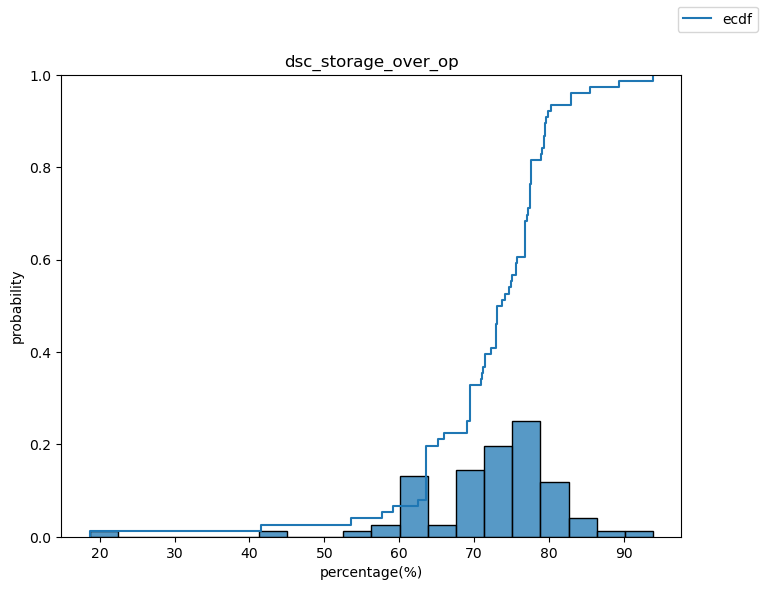

In [209]:
data = get_data('dsc', True, 'storage_over_op')
print('length of data: ', len(data))
print(data)
plot_hist_ecdf(data, 20, 'dsc', 'storage_over_op')

path:  ../optimizations/dsc/tracefiles_long
NaN:  0 []
path:  ../optimizations/dsc/tracefiles_long
NaN:  0 []
path:  ../optimizations/dsc/tracefiles_long
NaN:  0 []
path:  ../optimizations/dsc/tracefiles_long
NaN:  2 [PosixPath('../optimizations/dsc/tracefiles_long/crowdsale/withdraw'), PosixPath('../optimizations/dsc/tracefiles_long/bnb/withdrawEther')]
path:  ../optimizations/dsc/tracefiles_long
NaN:  0 []


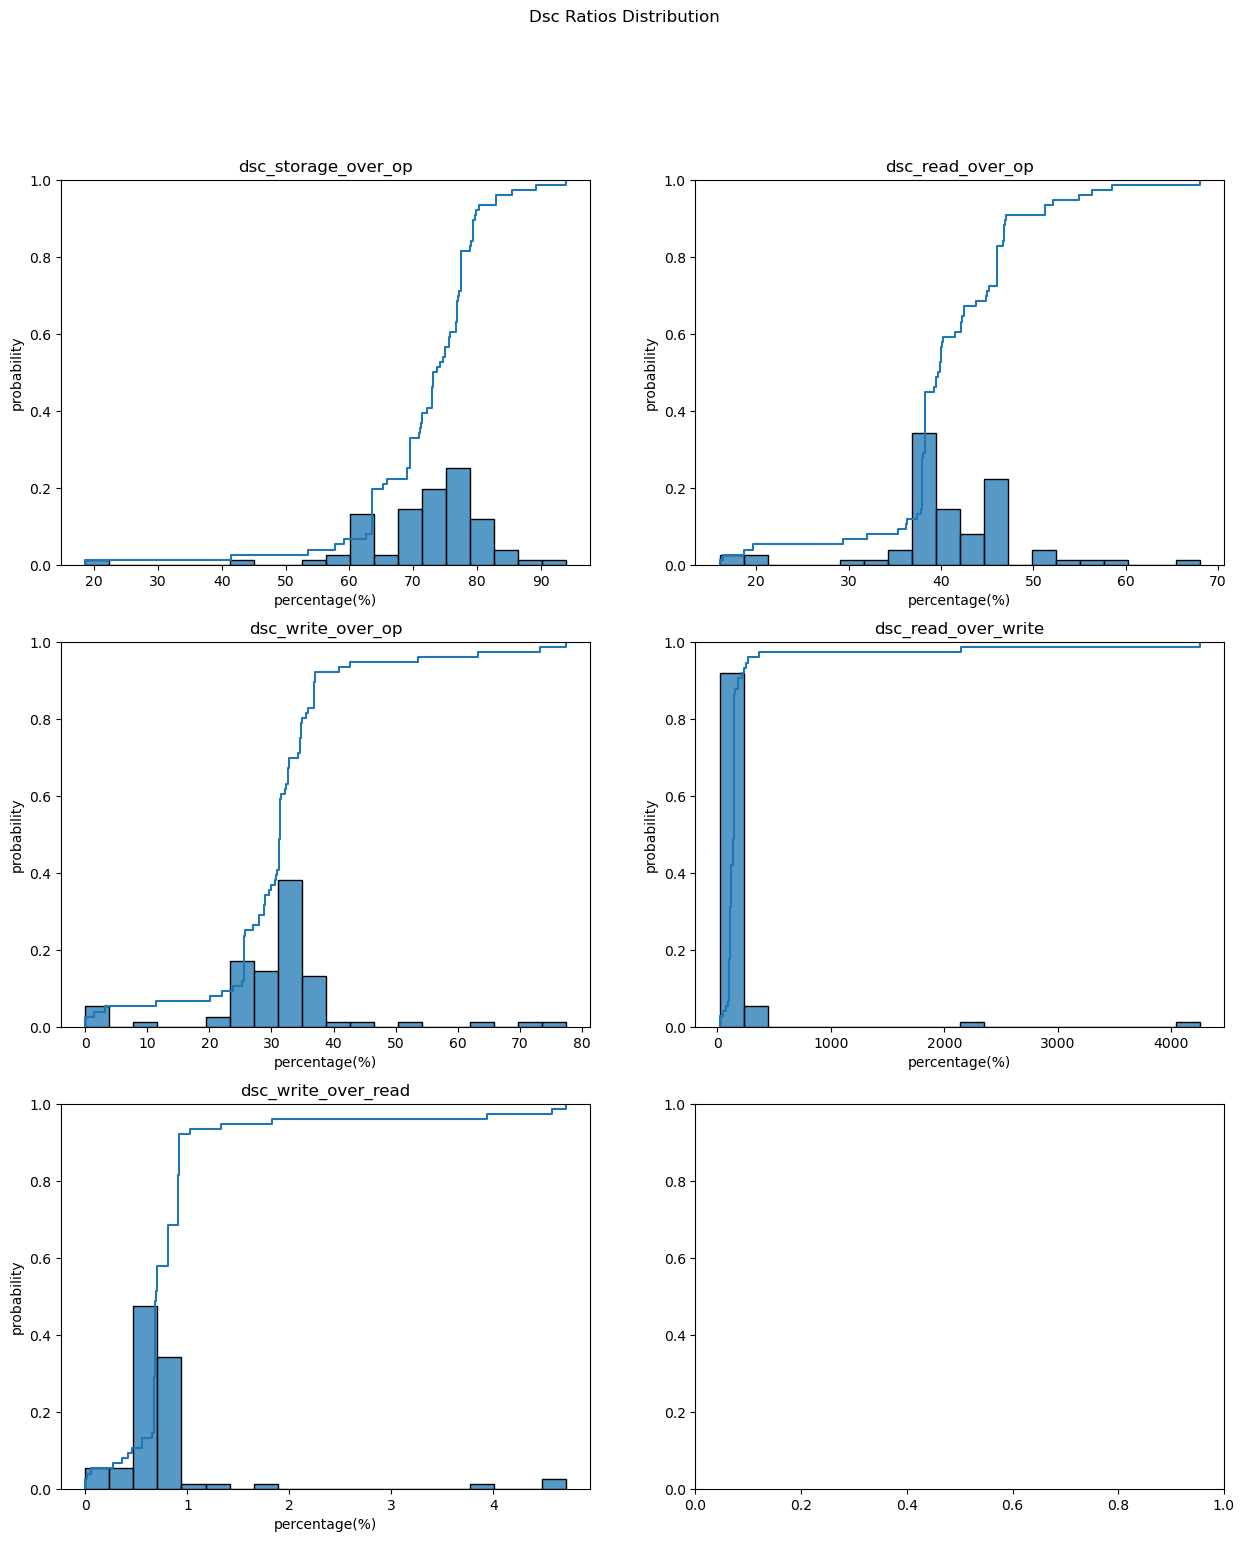

In [234]:
def plot_grouop(compiler, bins):
    data_storage_op = get_data(compiler, True, 'storage_over_op')
    data_read_op = get_data(compiler, True, 'read_over_op')
    data_write_op = get_data(compiler, True, 'write_over_op')
    data_read_write = get_data(compiler, True, 'read_over_write')
    data_write_read = get_data(compiler, True, 'write_over_read')
    fig, axes = plt.subplots(3, 2, figsize=(15, 17))
    fig.suptitle('Dsc Ratios Distribution')

    fig1 = sns.histplot(ax=axes[0, 0], data=data_storage_op, kde=False, stat='probability', bins=bins).set(title=f'dsc_storage_over_op')
    fig1 = sns.ecdfplot(ax=axes[0, 0], data=data_storage_op, label = 'ecdf')
    fig1.set(xlabel='percentage(%)', ylabel='probability')

    fig2 = sns.histplot(ax=axes[0, 1], data=data_read_op, kde=False, stat='probability', bins=bins).set(title=f'dsc_read_over_op')
    fig2 = sns.ecdfplot(ax=axes[0, 1], data=data_read_op, label = 'ecdf')
    fig2.set(xlabel='percentage(%)', ylabel='probability')

    fig3 = sns.histplot(ax=axes[1, 0], data=data_write_op, kde=False, stat='probability', bins=bins).set(title=f'dsc_write_over_op')
    fig3 = sns.ecdfplot(ax=axes[1, 0], data=data_write_op, label = 'ecdf')
    fig3.set(xlabel='percentage(%)', ylabel='probability')

    fig4 = sns.histplot(ax=axes[1, 1], data=data_read_write, kde=False, stat='probability', bins=bins).set(title=f'dsc_read_over_write')
    fig4 = sns.ecdfplot(ax=axes[1, 1], data=data_read_write, label = 'ecdf')
    fig4.set(xlabel='percentage(%)', ylabel='probability')

    fig5 = sns.histplot(ax=axes[2, 0], data=data_write_read, kde=False, stat='probability', bins=bins).set(title=f'dsc_write_over_read')
    fig5 = sns.ecdfplot(ax=axes[2, 0], data=data_write_read, label = 'ecdf')
    fig5.set(xlabel='percentage(%)', ylabel='probability')

plot_grouop('dsc', 20)

path:  ../optimizations/dsc/tracefiles_long
NaN:  0 []
length of data:  76
[29.35, 58.5, 42.23, 46.08, 40.01, 38.31, 42.22, 38.32, 37.96, 19.65, 39.48, 46.03, 40.12, 38.26, 38.29, 37.96, 68.02, 41.49, 16.46, 46.91, 46.8, 46.08, 39.95, 45.01, 56.4, 42.53, 37.96, 45.23, 32.02, 54.99, 46.03, 52.14, 37.96, 40.18, 46.08, 40.01, 37.89, 38.08, 37.36, 46.03, 38.26, 38.32, 37.96, 46.03, 39.66, 39.95, 38.26, 38.32, 37.96, 18.65, 39.3, 46.08, 40.01, 38.31, 38.32, 37.96, 47.03, 46.8, 51.29, 46.8, 44.91, 42.15, 42.53, 16.04, 37.96, 51.26, 46.71, 38.31, 39.47, 38.32, 37.96, 43.84, 37.97, 36.22, 36.36, 35.33]


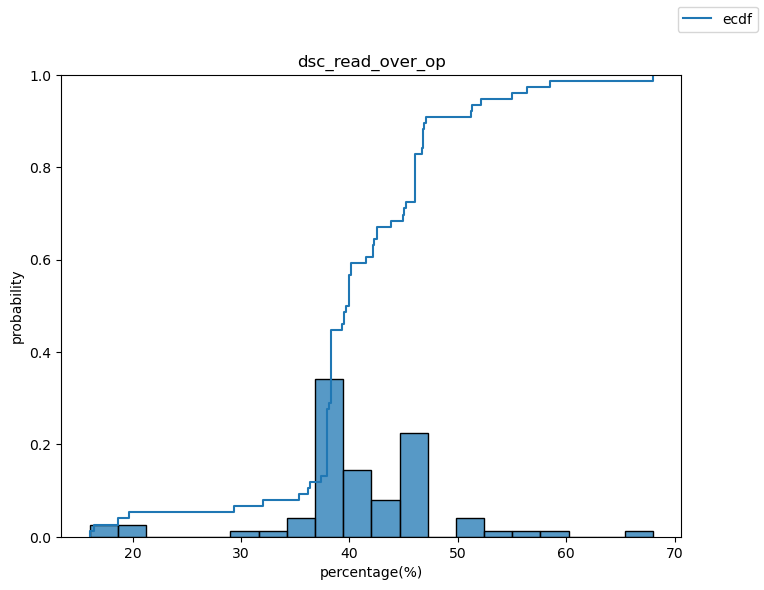

In [211]:
# data_dsc_long = get_data('dsc', True, 'read_over_op')
# data = get_data('dsc', True, 'storage_over_op')
# print('length of data: ', len(data))
# print(data)
# plot_hist_ecdf(data, 20)
data = get_data('dsc', True, 'read_over_op')
print('length of data: ', len(data))
print(data)
plot_hist_ecdf(data, 20, 'dsc', 'read_over_op')

path:  ../optimizations/dsc/tracefiles_long
NaN:  0 []
[53.63, 27.0, 11.34, 31.44, 36.83, 34.72, 28.81, 31.16, 25.6, 63.25, 25.75, 31.41, 36.94, 34.67, 31.14, 25.6, 3.16, 0.0, 77.45, 31.44, 36.83, 34.34, 30.96, 25.19, 31.41, 35.94, 36.78, 34.67, 31.16, 25.6, 0.0, 35.61, 28.05, 32.25, 34.72, 40.83, 31.16, 25.6, 29.91, 34.96, 32.82, 29.56, 23.83]
43


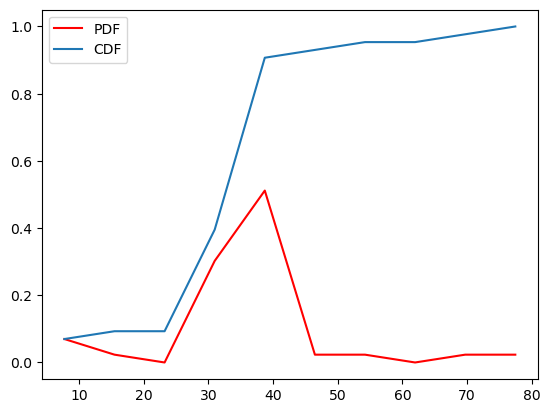

In [94]:
data_dsc_long = get_data('dsc', True, 'write_over_op')
print(data_dsc_long)
print(len(data_dsc_long))
plot_cdf(data_dsc_long, 10)

path:  ../optimizations/dsc/tracefiles_long
NaN:  2 [PosixPath('../optimizations/dsc/tracefiles_long/crowdsale/withdraw'), PosixPath('../optimizations/dsc/tracefiles_long/bnb/withdrawEther')]
[54.73, 216.67, 372.41, 146.55, 108.62, 110.34, 146.55, 122.99, 148.28, 250.6, 153.33, 146.55, 108.62, 110.34, 122.99, 148.28, 2150.0, 21.25, 146.55, 108.62, 110.34, 122.99, 148.28, 146.55, 110.34, 108.62, 110.34, 122.99, 148.28, 110.34, 182.76, 144.83, 110.34, 96.67, 122.99, 148.28, 146.55, 108.62, 110.34, 122.99, 148.28]
41
21.25 2150.0


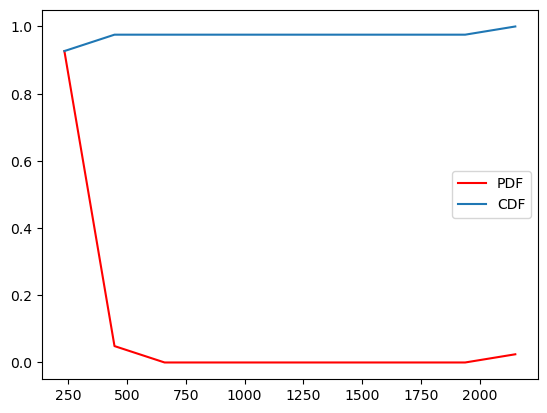

In [95]:
data_dsc_long= get_data('dsc', True, 'read_over_write')
print(data_dsc_long)
print(len(data_dsc_long))
print(x_min, x_max)
plot_cdf(data_dsc_long, 10)

path:  ../optimizations/dsc/tracefiles_long
NaN:  0 []
[1.83, 0.46, 0.27, 0.68, 0.92, 0.91, 0.68, 0.81, 0.67, 3.94, 0.65, 0.68, 0.92, 0.91, 0.81, 0.67, 0.05, 0.0, 4.71, 0.68, 0.92, 0.91, 0.81, 0.67, 0.68, 0.91, 0.92, 0.91, 0.81, 0.67, 0.0, 0.91, 0.55, 0.69, 0.91, 1.03, 0.81, 0.67, 0.68, 0.92, 0.91, 0.81, 0.67]
43


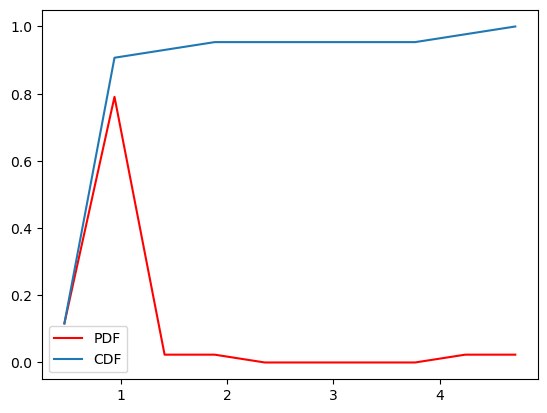

In [96]:
data_dsc_long = get_data('dsc', True, 'write_over_read')
print(data_dsc_long)
print(len(data_dsc_long))
plot_cdf(data_dsc_long, 10)

path:  ../optimizations/references/tracefiles_long
NaN:  0 []
[86.65, 93.47, 39.96, 76.35, 75.93, 57.95, 74.47, 70.08, 70.67, 59.07, 67.2, 59.28, 65.23, 61.17, 64.43, 65.09, 64.69, 60.92, 90.44, 62.93, 66.42, 73.39, 75.74, 86.79, 58.39, 71.72, 75.8, 61.47, 57.94, 81.68, 75.14, 71.3, 74.02, 82.07, 22.78, 75.38, 77.75, 78.53, 57.45, 71.28, 67.96, 61.18, 57.27, 42.66, 74.1, 71.16, 71.55]
47


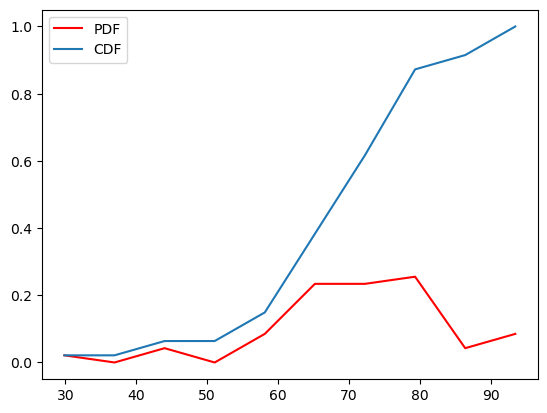

In [97]:
references_long = get_data('references', True, 'storage_over_op')
print(references_long)
print(len(references_long))
plot_cdf(references_long, 10)

path:  ../optimizations/references/tracefiles_long
NaN:  0 []
[30.2, 25.65, 16.78, 32.07, 31.89, 24.34, 31.28, 36.49, 29.68, 0.0, 34.99, 24.9, 27.4, 25.69, 35.2, 27.4, 27.22, 0.0, 15.7, 26.5, 36.32, 43.41, 75.03, 17.17, 25.19, 30.12, 31.84, 0.0, 24.99, 34.62, 31.99, 31.15, 32.2, 0.0, 22.78, 32.09, 45.99, 46.46, 24.13, 29.94, 28.54, 0.0, 24.05, 40.72, 31.12, 29.89, 35.15]
47


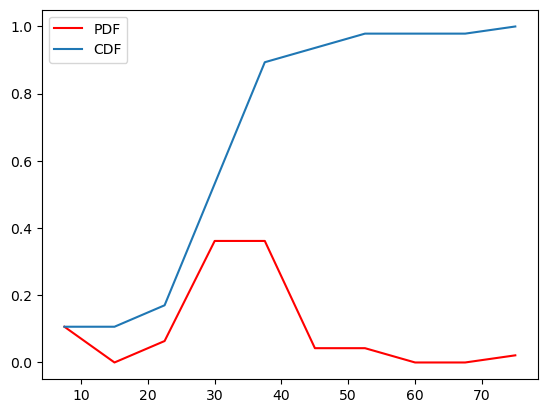

In [98]:
references_long = get_data('references', True, 'read_over_op')
print(references_long)
print(len(references_long))
plot_cdf(references_long, 10)

path:  ../optimizations/references/tracefiles_long
NaN:  0 []
[56.45, 67.82, 23.18, 44.28, 44.04, 33.61, 43.19, 33.59, 40.99, 59.07, 32.21, 34.38, 37.83, 35.48, 29.23, 37.68, 37.47, 60.92, 74.75, 36.44, 30.1, 29.97, 0.71, 69.62, 33.2, 41.6, 43.97, 61.47, 32.95, 47.06, 43.15, 40.15, 41.81, 82.07, 0.0, 43.29, 31.76, 32.08, 33.32, 41.34, 39.42, 61.18, 33.21, 1.94, 42.98, 41.27, 36.4]
47


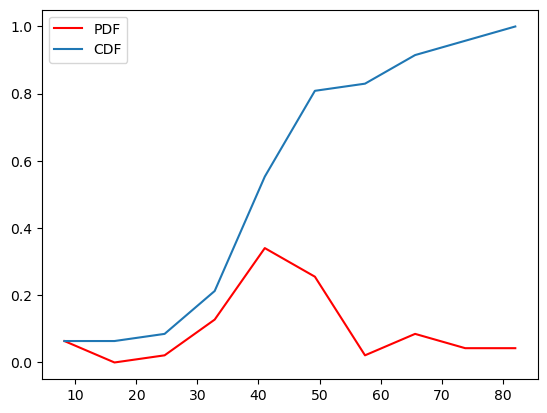

In [99]:
references_long = get_data('references', True, 'write_over_op')
print(references_long)
print(len(references_long))
plot_cdf(references_long, 10)

path:  ../optimizations/references/tracefiles_long
NaN:  1 [PosixPath('../optimizations/references/tracefiles_long/bnb/withdrawEther')]
[53.5, 37.83, 72.41, 72.41, 72.41, 72.41, 72.41, 108.62, 72.41, 0.0, 108.62, 72.41, 72.41, 72.41, 120.45, 72.73, 72.65, 0.0, 21.0, 72.73, 120.69, 144.83, 10600.0, 24.67, 75.86, 72.41, 72.41, 0.0, 75.86, 73.56, 74.14, 77.59, 77.01, 0.0, 74.14, 144.83, 144.83, 72.41, 72.41, 72.41, 0.0, 72.41, 2100.0, 72.41, 72.41, 96.59]
46


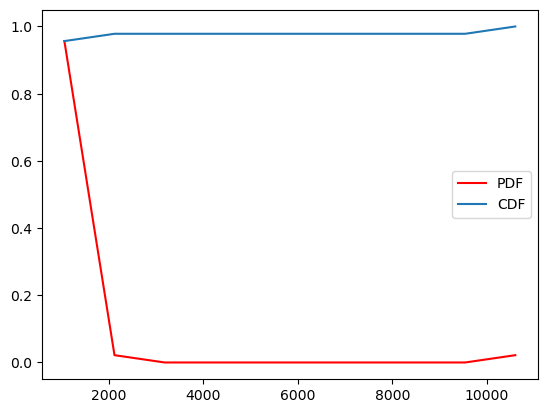

In [100]:
references_long = get_data('references', True, 'read_over_write')
print(references_long)
print(len(references_long))
plot_cdf(references_long, 10)

path:  ../optimizations/references/tracefiles_long
NaN:  5 [PosixPath('../optimizations/references/tracefiles_long/controllable/approve'), PosixPath('../optimizations/references/tracefiles_long/erc777/approve'), PosixPath('../optimizations/references/tracefiles_long/link/approve'), PosixPath('../optimizations/references/tracefiles_long/bnb/approve'), PosixPath('../optimizations/references/tracefiles_long/ltcSwapAsset/approve')]
[1.87, 2.64, 1.38, 1.38, 1.38, 1.38, 1.38, 0.92, 1.38, 0.92, 1.38, 1.38, 1.38, 0.83, 1.38, 1.38, 4.76, 1.38, 0.83, 0.69, 0.01, 4.05, 1.32, 1.38, 1.38, 1.32, 1.36, 1.35, 1.29, 1.3, 0.0, 1.35, 0.69, 0.69, 1.38, 1.38, 1.38, 1.38, 0.05, 1.38, 1.38, 1.04]
42


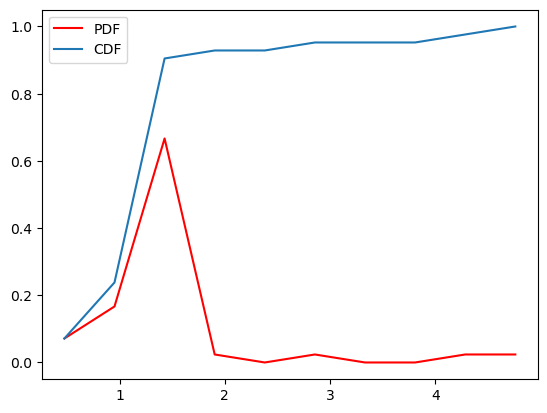

In [102]:
references_long= get_data('references', True, 'write_over_read')
print(references_long)
print(len(references_long))
plot_cdf(references_long, 10)

path:  ../optimizations/dsc-fused-operator/tracefiles_long
NaN:  0 []
[82.98, 85.5, 81.24, 79.74, 76.74, 74.25, 73.2, 66.11, 82.91, 65.22, 81.13, 79.97, 76.63, 73.14, 66.11, 71.18, 41.49, 93.91, 81.24, 79.74, 75.86, 72.71, 65.01, 81.13, 79.4, 79.63, 76.63, 73.2, 66.11, 18.71, 79.97, 82.68, 81.55, 76.74, 80.66, 73.2, 66.11, 77.84, 76.38, 73.11, 69.92, 61.82]
42


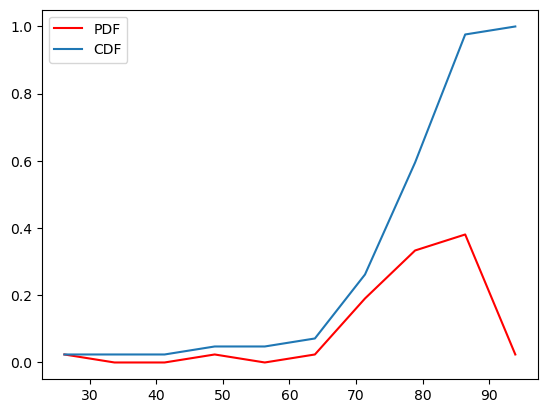

In [103]:
fused_long = get_data('dsc-fused-operator', True, 'storage_over_op')
print(fused_long)
print(len(fused_long))
plot_cdf(fused_long, 10)

path:  ../optimizations/dsc-fused-operator/tracefiles_long
NaN:  0 []
[29.35, 58.5, 48.29, 41.52, 40.26, 44.14, 40.37, 39.48, 19.65, 39.48, 48.23, 41.64, 40.2, 40.34, 39.48, 68.02, 41.49, 16.46, 48.29, 41.52, 39.8, 40.1, 38.83, 48.23, 41.65, 41.46, 40.2, 40.37, 39.48, 18.71, 41.95, 53.44, 48.24, 40.26, 39.64, 40.37, 39.48, 46.27, 39.77, 38.35, 38.57, 36.92]
42


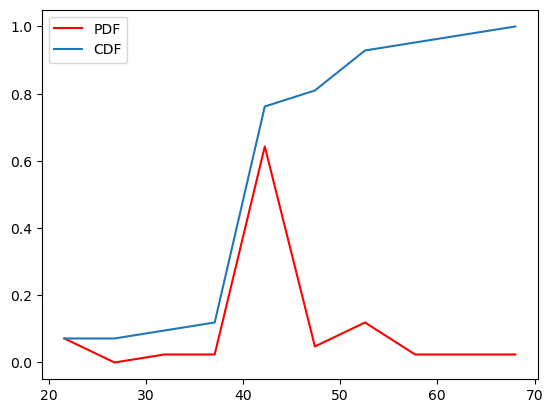

In [104]:
fused_long = get_data('dsc-fused-operator', True, 'read_over_op')
print(fused_long)
print(len(fused_long))
plot_cdf(fused_long, 10)

path:  ../optimizations/dsc-fused-operator/tracefiles_long
NaN:  0 []
[53.63, 27.0, 32.95, 38.22, 36.48, 30.12, 32.83, 26.63, 63.25, 25.75, 32.91, 38.33, 36.43, 32.8, 26.63, 3.16, 0.0, 77.45, 32.95, 38.22, 36.07, 32.61, 26.19, 32.91, 37.75, 38.17, 36.43, 32.83, 26.63, 0.0, 38.02, 29.24, 33.31, 36.48, 41.01, 32.83, 26.63, 31.57, 36.61, 34.76, 31.36, 24.9]
42


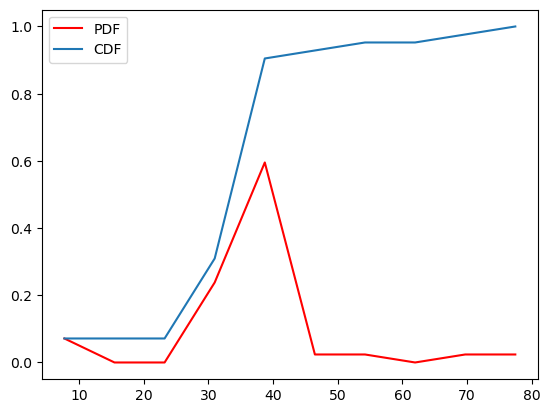

In [105]:
fused_long = get_data('dsc-fused-operator', True, 'write_over_op')
print(fused_long)
print(len(fused_long))
plot_cdf(fused_long, 10)

path:  ../optimizations/dsc-fused-operator/tracefiles_long
NaN:  2 [PosixPath('../optimizations/dsc-fused-operator/tracefiles_long/crowdsale/withdraw'), PosixPath('../optimizations/dsc-fused-operator/tracefiles_long/bnb/withdrawEther')]
[54.73, 216.67, 146.55, 108.62, 110.34, 146.55, 122.99, 148.28, 250.6, 153.33, 146.55, 108.62, 110.34, 122.99, 148.28, 2150.0, 21.25, 146.55, 108.62, 110.34, 122.99, 148.28, 146.55, 110.34, 108.62, 110.34, 122.99, 148.28, 110.34, 182.76, 144.83, 110.34, 96.67, 122.99, 148.28, 146.55, 108.62, 110.34, 122.99, 148.28]
40


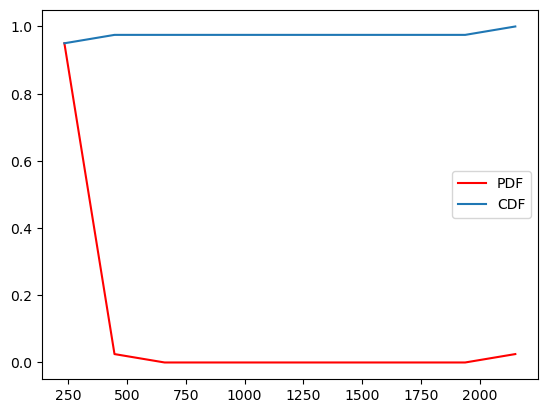

In [106]:
fused_long = get_data('dsc-fused-operator', True, 'read_over_write')
print(fused_long)
print(len(fused_long))
plot_cdf(fused_long, 10)

path:  ../optimizations/dsc-fused-operator/tracefiles_long
NaN:  0 []
[1.83, 0.46, 0.68, 0.92, 0.91, 0.68, 0.81, 0.67, 3.94, 0.65, 0.68, 0.92, 0.91, 0.81, 0.67, 0.05, 0.0, 4.71, 0.68, 0.92, 0.91, 0.81, 0.67, 0.68, 0.91, 0.92, 0.91, 0.81, 0.67, 0.0, 0.91, 0.55, 0.69, 0.91, 1.03, 0.81, 0.67, 0.68, 0.92, 0.91, 0.81, 0.67]
42


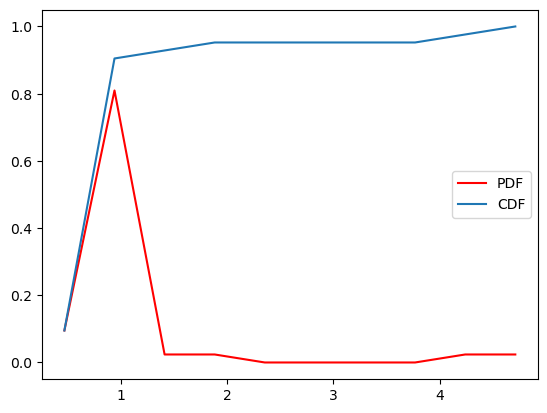

In [107]:
fused_long = get_data('dsc-fused-operator', True, 'write_over_read')
print(fused_long)
print(len(fused_long))
plot_cdf(fused_long, 10)